Dans nous voullons developper un modele prediction de la temperature du module
en utilisant les modeles statiques d'auto regressions 

In [1]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller,acf
from statsmodels.tsa.arima.model import ARIMA
from  pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import warnings
warnings.filterwarnings('ignore')
from  pandas.tseries.offsets import DateOffset
import seaborn as sms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
missing_values=["na","-","I"]
bokhol=pd.read_excel('basedonnees.xlsx',na_values=missing_values,index_col=[0],parse_dates=True)

In [3]:
bokhol.head()

,W2- Irradiance (W/m²),W3 - Irradiance (W/m²),W4 - Irradiance (W/m²),Temperature ambiante (°C),Vitesse du vent (m/s),Température module (°C),Production Centrale Meter 1 - (W)
Date (+00:00),,,,,,,
2021-01-01 00:05:00,0.0,0.0,0.0,21.9667,1.7416,25.9,0.0
2021-01-01 00:10:00,0.0,0.0,0.0,21.9667,1.7416,25.9,0.0
2021-01-01 00:15:00,0.0,0.0,0.0,21.9667,1.7416,25.9,0.0
2021-01-01 00:20:00,0.0,0.0,0.0,21.9667,1.7416,25.9,0.0
2021-01-01 00:25:00,0.0,0.0,0.0,21.9667,1.7416,25.9,0.0


In [4]:
bokhol.isnull().sum()

W2- Irradiance (W/m²)                 50
W3 - Irradiance (W/m²)                59
W4 - Irradiance (W/m²)                57
 Temperature ambiante (°C)            45
 Vitesse du vent (m/s)                42
Température module (°C)              247
Production Centrale Meter 1 - (W)    617
dtype: int64

In [5]:
bokhol=bokhol.dropna(axis=0)

In [6]:
bokhol.var()

W2- Irradiance (W/m²)                1.206854e+05
W3 - Irradiance (W/m²)               1.164649e+05
W4 - Irradiance (W/m²)               1.205873e+05
 Temperature ambiante (°C)           2.666369e+01
 Vitesse du vent (m/s)               2.157260e+00
Température module (°C)              4.161356e+01
Production Centrale Meter 1 - (W)    3.640470e+13
dtype: float64

Verification et traitement des valeurs aberante 

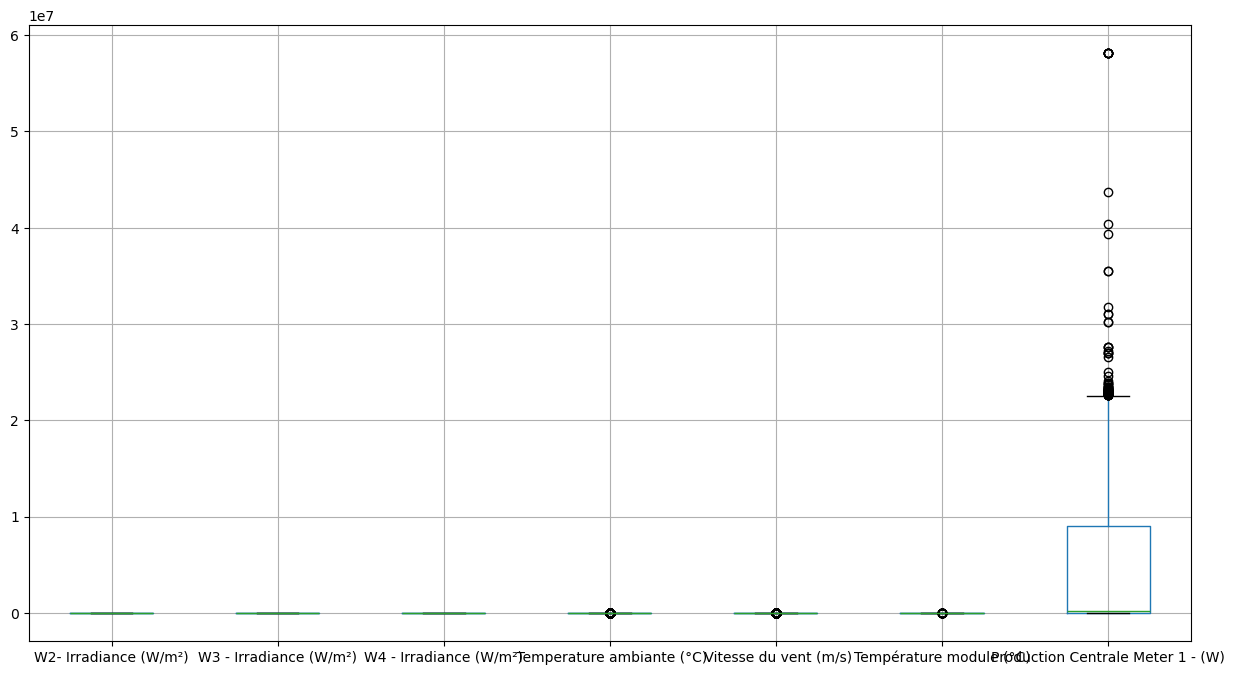

In [7]:
plt.figure(figsize=(15,8))
bokhol.boxplot();

In [8]:
def detect_outlier_iqr(data,colonnes):
    Q1=data[colonnes].quantile(0.25)
    Q3=data[colonnes].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3-1.5*IQR
    return data.loc[data[colonnes]<lower_bound,colonnes]|data.loc[data[colonnes]<upper_bound,colonnes]

#outlier_iqr=detect_outlier_iqr(bokhol,'Production Centrale Meter 1 - (W)') 
#outlier_iqr

In [9]:
"""features=np.array(bokhol.columns)

for fetuare in features:
     outlier_iqr=detect_outlier_iqr(bokhol,fetuare)

outlier_iqr"""

'features=np.array(bokhol.columns)\n\nfor fetuare in features:\n     outlier_iqr=detect_outlier_iqr(bokhol,fetuare)\n\noutlier_iqr'

In [10]:
"""Q1=bokhol['Production Centrale Meter 1 - (W)'].quantile(0.75)
Q3=bokhol['Production Centrale Meter 1 - (W)'].quantile(0.95)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3-1.5*IQR
#abrv=bokhol.loc[bokhol['Production Centrale Meter 1 - (W)']<lower_bound]
bokhol.loc[bokhol['Production Centrale Meter 1 - (W)']>upper_bound]=upper_bound"""


"Q1=bokhol['Production Centrale Meter 1 - (W)'].quantile(0.75)\nQ3=bokhol['Production Centrale Meter 1 - (W)'].quantile(0.95)\nIQR=Q3-Q1\nlower_bound=Q1-1.5*IQR\nupper_bound=Q3-1.5*IQR\n#abrv=bokhol.loc[bokhol['Production Centrale Meter 1 - (W)']<lower_bound]\nbokhol.loc[bokhol['Production Centrale Meter 1 - (W)']>upper_bound]=upper_bound"

In [11]:
#bokhol.boxplot();

In [12]:
def detect_outliers_zscore(data, column, threshold=2):
    Limite_inférieure=data[column].mean()-3*data[column].std()
    Limite_supérieure=data[column].mean()+3*data[column].std()
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    return data[np.abs(z_scores) > threshold]


outliers = detect_outliers_zscore(bokhol, 'Production Centrale Meter 1 - (W)')
outliers.size

42371

In [13]:
liste=list(bokhol.columns)
list_1=liste[0:5]

production=bokhol.drop(list_1,axis=1)

production

,Température module (°C),Production Centrale Meter 1 - (W)
Date (+00:00),,
2021-01-01 00:05:00,25.9,0.0
2021-01-01 00:10:00,25.9,0.0
2021-01-01 00:15:00,25.9,0.0
2021-01-01 00:20:00,25.9,0.0
2021-01-01 00:25:00,25.9,0.0
...,...,...
2021-12-31 20:40:00,26.8,0.0
2021-12-31 20:45:00,26.6,0.0
2021-12-31 20:50:00,26.3,0.0


In [14]:
T_module=production.drop(liste[-1],axis=1)
T_module

,Température module (°C)
Date (+00:00),
2021-01-01 00:05:00,25.9
2021-01-01 00:10:00,25.9
2021-01-01 00:15:00,25.9
2021-01-01 00:20:00,25.9
2021-01-01 00:25:00,25.9
...,...
2021-12-31 20:40:00,26.8
2021-12-31 20:45:00,26.6
2021-12-31 20:50:00,26.3


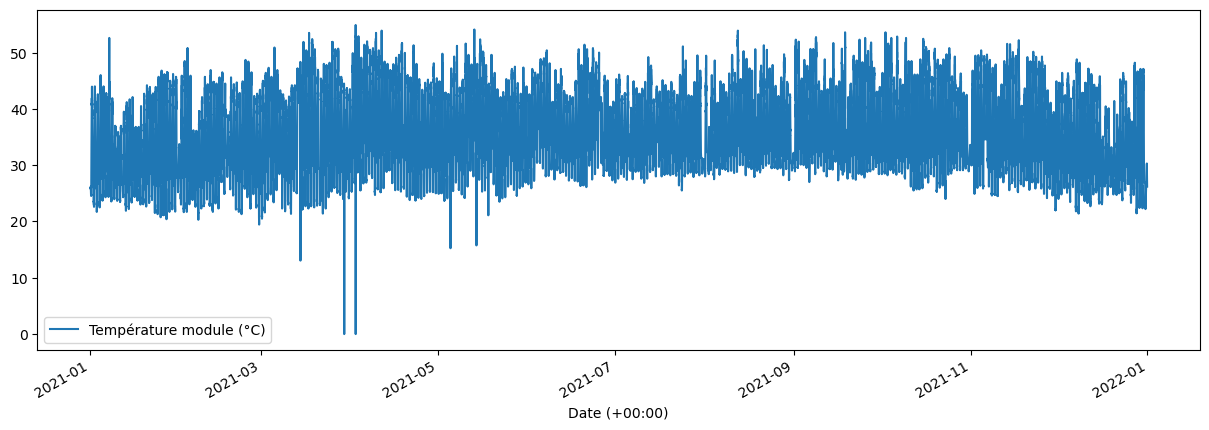

In [15]:
T_module.plot(figsize=(15,5));

Test de la stationnarite de la serie

In [16]:
adfuller(T_module)

(-42.651347672074905,
 0.0,
 35,
 104202,
 {'1%': -3.430412757539186,
  '5%': -2.861567737861426,
  '10%': -2.566784763890878},
 183077.50476284398)

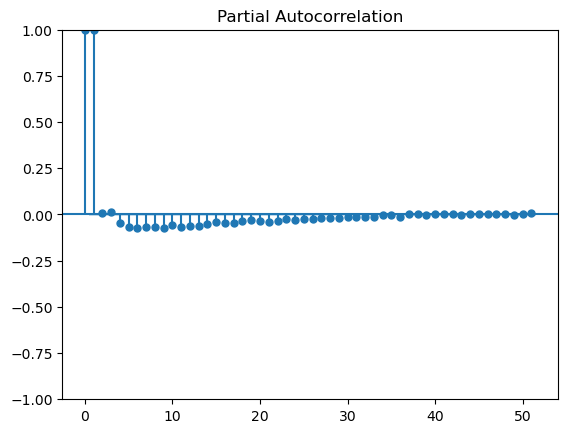

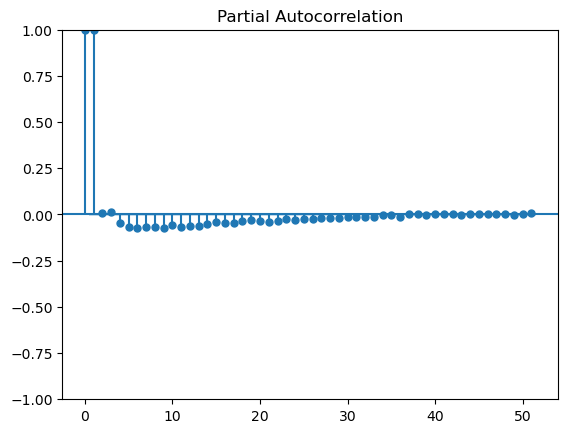

In [17]:
plot_pacf(T_module)

In [18]:
from pmdarima import auto_arima


#orderModel=auto_arima(T_module,trace=True,supress_warnings=True)

MODELE ARIMA(p,d,q)

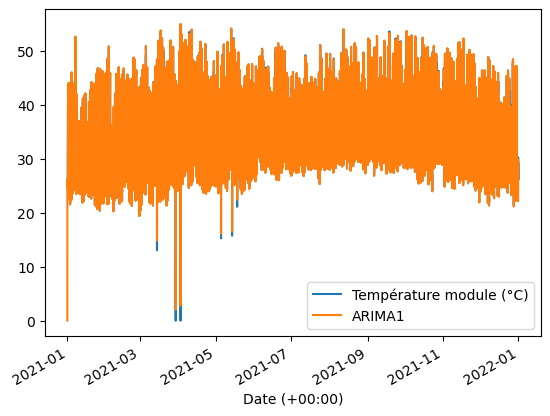

In [19]:
model=ARIMA(T_module.values,order=(2,1,4))
model_fit=model.fit()

T_module['ARIMA1']=model_fit.predict()
T_module.plot();

In [22]:
T_module.index

DatetimeIndex(['2021-01-01 00:05:00', '2021-01-01 00:10:00',
               '2021-01-01 00:15:00', '2021-01-01 00:20:00',
               '2021-01-01 00:25:00', '2021-01-01 00:30:00',
               '2021-01-01 00:35:00', '2021-01-01 00:40:00',
               '2021-01-01 00:45:00', '2021-01-01 00:50:00',
               ...
               '2021-12-31 20:15:00', '2021-12-31 20:20:00',
               '2021-12-31 20:25:00', '2021-12-31 20:30:00',
               '2021-12-31 20:35:00', '2021-12-31 20:40:00',
               '2021-12-31 20:45:00', '2021-12-31 20:50:00',
               '2021-12-31 20:55:00', '2021-12-31 21:00:00'],
              dtype='datetime64[ns]', name='Date (+00:00)', length=104238, freq=None)

KeyError: '2021-01-01 00:05:00'

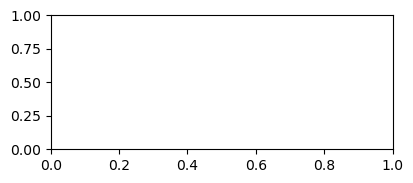

In [23]:
mois=['2021-01-01 00:05:00','2021-02-28 ','2021-03-31','2021-04-30',
               '2021-05-31','2021-06-30',
               '2021-07-31','2021-08-31',
               '2021-09-30','2021-10-31',
               '2021-11-30','2021-12-31']

fig=plt.figure(figsize=(15,8))
for i,j in enumerate(mois):
    
    ax=fig.add_subplot(4,3,1+i)
    ax.plot(T_module[j])


plt.savefig('stimmation_par_mois.png')  

modele de prediction de la temperature du module PV

In [ ]:
list_2=T_module.columns
T_module.drop(list_2[-1],axis=1,inplace=True)
T_module

,Température module (°C)
Date (+00:00),
2021-01-01 00:05:00,25.9
2021-01-01 00:10:00,25.9
2021-01-01 00:15:00,25.9
2021-01-01 00:20:00,25.9
2021-01-01 00:25:00,25.9
...,...
2021-12-31 20:40:00,26.8
2021-12-31 20:45:00,26.6
2021-12-31 20:50:00,26.3


In [ ]:
T_module_train=T_module.iloc[:-12]

T_module_test=T_module.iloc[-12:]

model_2=ARIMA(T_module_train,order=(2,1,4))
model_fit_2=model_2.fit()

Validation du modele

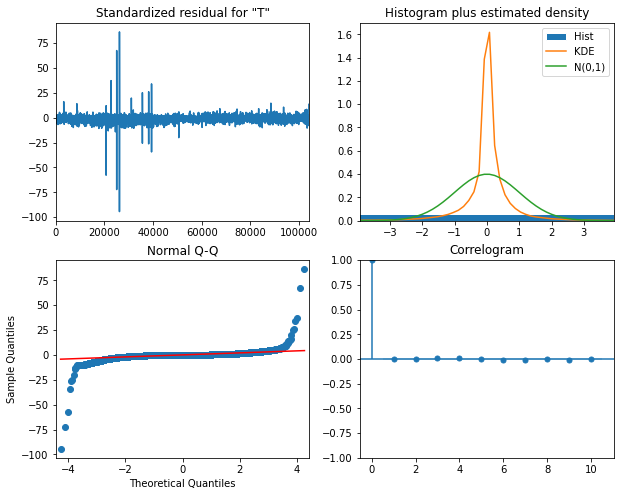

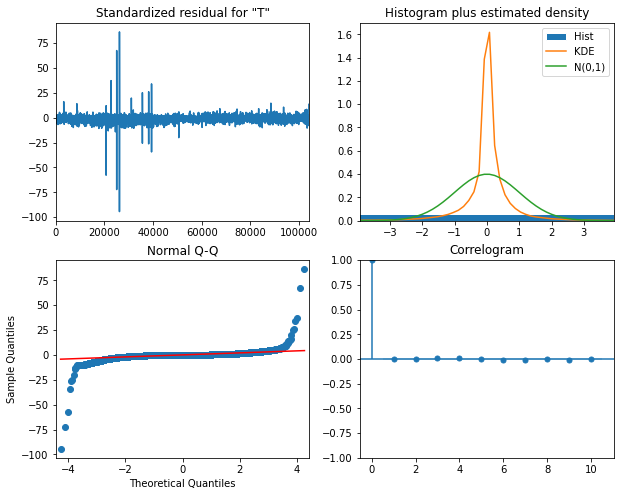

In [ ]:
model_fit_2.plot_diagnostics(figsize=(10, 8))

PREDICTION

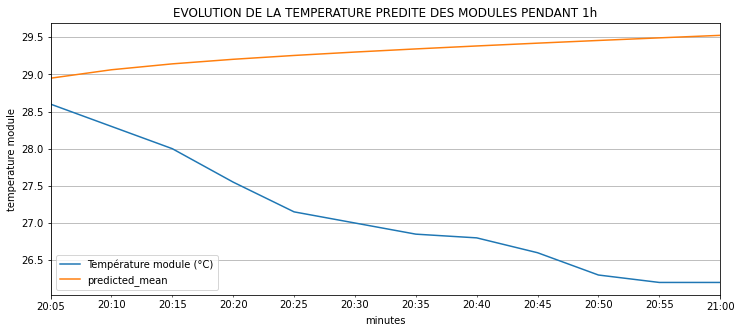

In [ ]:
horizon=T_module_test.shape[0] #TC_test.shape[0]+TC_dp.shape[0]
T_module_predite=model_fit_2.forecast(steps=horizon)

#donnees_futures=pd.date_range(T_module.index[-1],periods=T_module_test.shape[0],freq='00h05t')
T_module_predite.index=T_module_test.index

T_module_test.plot()
T_module_predite.plot(figsize=(12,5))
plt.xlabel('minutes')
plt.ylabel('temperature module')
plt.title('EVOLUTION DE LA TEMPERATURE PREDITE DES MODULES PENDANT 1h')
plt.legend()
plt.grid()

In [ ]:
print('L''erreur absolu moyenne:',mean_absolute_error(T_module_test,T_module_predite))
print('L''erreur quadratique moyenne:',np.sqrt(mean_squared_error(T_module_test,T_module_predite)))
print('Le coeffient de determination:',r2_score(T_module_test,T_module_predite))

Lerreur absolu moyenne: 2.1652020116319766
Lerreur quadratique moyenne: 2.365812755684239
Le coeffient de determination: -8.116625617441823


In [ ]:
a = 'Hello'; b = 'World'
c=a+""+b
c

'HelloWorld'